In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, utils
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_and_preprocess_data(base_path, categories, img_size=(224, 224)):
    data = []
    for label, category in enumerate(categories):
        cat_dir = os.path.join(base_path, category)
        for fname in os.listdir(cat_dir):
            p = os.path.join(cat_dir, fname)
            if os.path.isfile(p) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(p)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    data.append((img, label))
    random.shuffle(data)
    X = np.array([d[0] for d in data])
    y = np.array([d[1] for d in data])
    return X, y

In [4]:
# Load data
categories = ['with_mask', 'without_mask']
X, y = load_and_preprocess_data(
    '/content/drive/MyDrive/Images Dataset/train', categories
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
y_train = utils.to_categorical(y_train, num_classes=2)
y_test  = utils.to_categorical(y_test,  num_classes=2)

In [5]:
# Model components
normalizer = layers.Rescaling(1.0 / 255)
dense_net  = DenseNet121(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)
dense_net.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Build & compile
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    normalizer,
    dense_net,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,418 (27.85 MB)

 Trainable params: 262,914 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

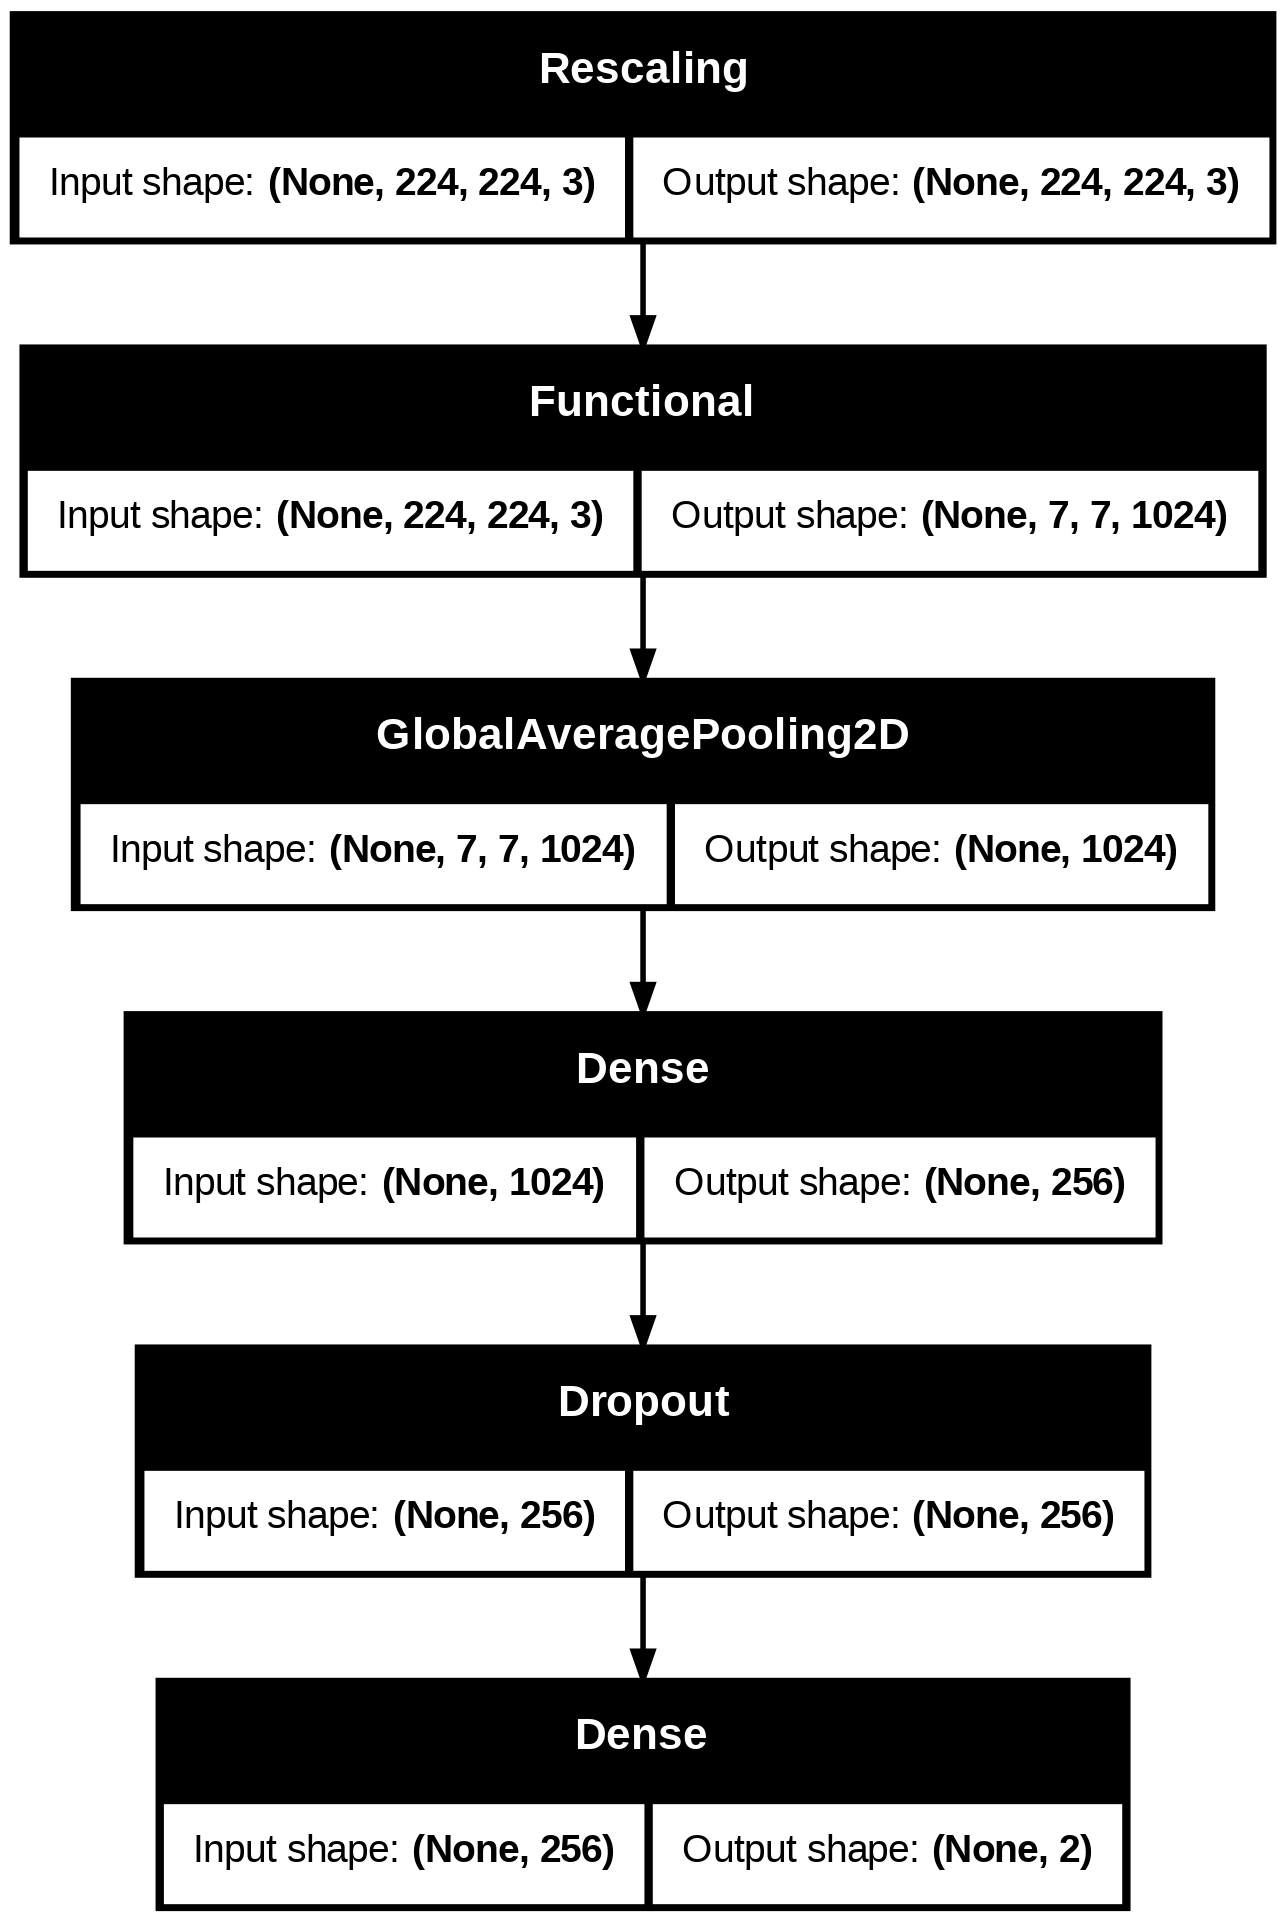

In [7]:
utils.plot_model(model, to_file='model_diagram.png', show_shapes=True)

In [8]:
# Augmentation & callbacks
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True
)


In [9]:
# Training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train)//32,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

# Evaluation
model.load_weights('best_model.h5')
preds = model.predict(X_test).argmax(axis=1)
true  = y_test.argmax(axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.7540 - loss: 0.5362

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7553 - loss: 0.5337 - val_accuracy: 0.8490 - val_loss: 0.3041
Epoch 2/20
 1/30 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8125 - loss: 0.4263

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8125 - loss: 0.4263 - val_accuracy: 0.8408 - val_loss: 0.3123
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 448ms/step - accuracy: 0.8251 - loss: 0.3733 - val_accuracy: 0.8449 - val_loss: 0.3342
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9062 - loss: 0.3243 - val_accuracy: 0.8612 - val_loss: 0.3201
Epoch 4: early stopping
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


              precision    recall  f1-score   support

   with_mask       0.80      0.69      0.74        77
without_mask       0.87      0.92      0.89       168

    accuracy                           0.85       245
   macro avg       0.83      0.81      0.82       245
weighted avg       0.85      0.85      0.85       245



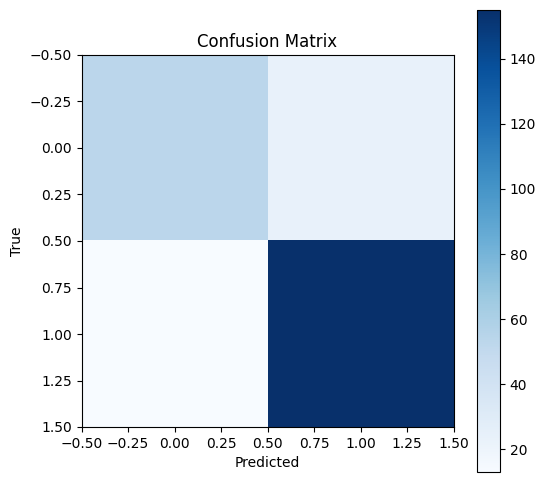

In [10]:
print(classification_report(true, preds, target_names=categories))
cm = confusion_matrix(true, preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar(); plt.show()